In [4]:
import pandas as pd

df = pd.read_csv("Cricket_WC23.csv")

df.head()


,Team 1,Team 2,Winner,Margin,Ground,Match Date,MATCH_ID
0,India,Australia,Australia,6 wickets,Ahmedabad,"Nov 19, 2023",ODI # 4705
1,Australia,South Africa,Australia,3 wickets,Eden Gardens,"Nov 16, 2023",ODI # 4704
2,India,New Zealand,India,70 runs,Wankhede,"Nov 15, 2023",ODI # 4703
3,India,Netherlands,India,160 runs,Bengaluru,"Nov 12, 2023",ODI # 4702
4,England,Pakistan,England,93 runs,Eden Gardens,"Nov 11, 2023",ODI # 4701


In [5]:
df["Win_Type"] = df["Margin"].str.lower().str.extract(r"(runs|wickets)")


In [6]:
df["Team1_Batting"] = None
df["Team2_Batting"] = None


In [7]:
# Case 1: Winner won by wickets (winner batted second)
mask_wickets = df["Win_Type"] == "wickets"

df.loc[mask_wickets & (df["Winner"] == df["Team 1"]), "Team1_Batting"] = "Batted Second"
df.loc[mask_wickets & (df["Winner"] == df["Team 1"]), "Team2_Batting"] = "Batted First"

df.loc[mask_wickets & (df["Winner"] == df["Team 2"]), "Team2_Batting"] = "Batted Second"
df.loc[mask_wickets & (df["Winner"] == df["Team 2"]), "Team1_Batting"] = "Batted First"


# Case 2: Winner won by runs (winner batted first)
mask_runs = df["Win_Type"] == "runs"

df.loc[mask_runs & (df["Winner"] == df["Team 1"]), "Team1_Batting"] = "Batted First"
df.loc[mask_runs & (df["Winner"] == df["Team 1"]), "Team2_Batting"] = "Batted Second"

df.loc[mask_runs & (df["Winner"] == df["Team 2"]), "Team2_Batting"] = "Batted First"
df.loc[mask_runs & (df["Winner"] == df["Team 2"]), "Team1_Batting"] = "Batted Second"


In [8]:
df[["Team 1", "Team1_Batting", "Team 2", "Team2_Batting", "Winner", "Margin"]].head()


,Team 1,Team1_Batting,Team 2,Team2_Batting,Winner,Margin
0,India,Batted First,Australia,Batted Second,Australia,6 wickets
1,Australia,Batted Second,South Africa,Batted First,Australia,3 wickets
2,India,Batted First,New Zealand,Batted Second,India,70 runs
3,India,Batted First,Netherlands,Batted Second,India,160 runs
4,England,Batted First,Pakistan,Batted Second,England,93 runs


In [9]:
team_level_df = pd.concat(
    [
        df[["Team 1", "Team1_Batting"]]
        .rename(columns={"Team 1": "Team", "Team1_Batting": "Batting_Order"}),

        df[["Team 2", "Team2_Batting"]]
        .rename(columns={"Team 2": "Team", "Team2_Batting": "Batting_Order"})
    ],
    ignore_index=True
)


In [10]:
team_level_df.head(10)


,Team,Batting_Order
0,India,Batted First
1,Australia,Batted Second
2,India,Batted First
3,India,Batted First
4,England,Batted First
5,Australia,Batted Second
6,Afghanistan,Batted First
7,New Zealand,Batted Second
8,England,Batted First
9,Afghanistan,Batted First


In [11]:
team_batting_counts = (
    team_level_df
    .groupby(["Team", "Batting_Order"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)


In [12]:
team_batting_counts


Batting_Order,Team,Batted First,Batted Second
0,Afghanistan,5,4
1,Australia,5,6
2,Bangladesh,4,5
3,England,5,4
4,India,6,5
5,Netherlands,4,5
6,New Zealand,3,7
7,Pakistan,4,4
8,South Africa,6,3
9,Sri Lanka,5,4


In [13]:
team_batting_counts["Total"] = (
    team_batting_counts.get("Batted First", 0) +
    team_batting_counts.get("Batted Second", 0)
)

team_batting_counts.sort_values("Total", ascending=False).head(10)


Batting_Order,Team,Batted First,Batted Second,Total
1,Australia,5,6,11
4,India,6,5,11
6,New Zealand,3,7,10
0,Afghanistan,5,4,9
3,England,5,4,9
2,Bangladesh,4,5,9
5,Netherlands,4,5,9
8,South Africa,6,3,9
9,Sri Lanka,5,4,9
7,Pakistan,4,4,8


In [14]:
df["Win_Type"] = df["Margin"].str.lower().str.extract(r"(runs|wickets)")


In [15]:
df["Winner_Batting"] = df["Win_Type"].map({
    "runs": "Batted First",
    "wickets": "Batted Second"
})


In [16]:
batting_order_wins = df["Winner_Batting"].value_counts().reset_index()
batting_order_wins.columns = ["Batting_Order", "Wins"]

batting_order_wins


,Batting_Order,Wins
0,Batted First,24
1,Batted Second,23


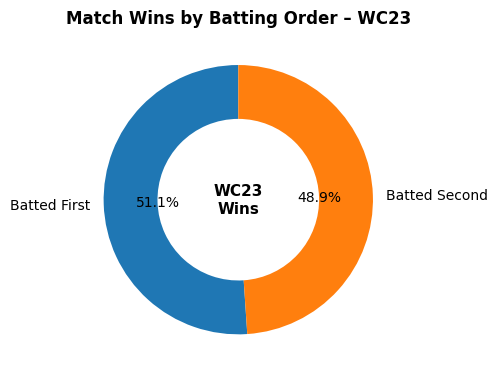

In [17]:
import matplotlib.pyplot as plt

labels = batting_order_wins["Batting_Order"]
sizes = batting_order_wins["Wins"]

plt.figure(figsize=(5, 5))

wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops=dict(width=0.4)
)

plt.text(
    0, 0,
    "WC23\nWins",
    ha="center",
    va="center",
    fontsize=11,
    weight="bold"
)

plt.title(
    "Match Wins by Batting Order – WC23",
    fontsize=12,
    weight="bold"
)

plt.tight_layout()
plt.show()


In [18]:
total_matches = batting_order_wins["Wins"].sum()

batting_order_wins["Win %"] = (
    batting_order_wins["Wins"] / total_matches * 100
).round(2)

batting_order_wins


,Batting_Order,Wins,Win %
0,Batted First,24,51.06
1,Batted Second,23,48.94


In [19]:
df["Ground"].value_counts().reset_index().rename(
    columns={"index": "Ground", "Ground": "Matches"}
)


,Matches,count
0,Ahmedabad,5
1,Eden Gardens,5
2,Wankhede,5
3,Bengaluru,5
4,Pune,5
5,Delhi,5
6,Lucknow,5
7,Dharamsala,5
8,Chennai,5
9,Hyderabad,3


In [20]:
ground_batting_wins = (
    df.groupby(["Ground", "Winner_Batting"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

ground_batting_wins


Winner_Batting,Ground,Batted First,Batted Second
0,Ahmedabad,1,4
1,Bengaluru,3,2
2,Chennai,1,3
3,Delhi,3,2
4,Dharamsala,3,2
5,Eden Gardens,3,2
6,Hyderabad,2,1
7,Lucknow,2,3
8,Pune,2,3
9,Wankhede,4,1


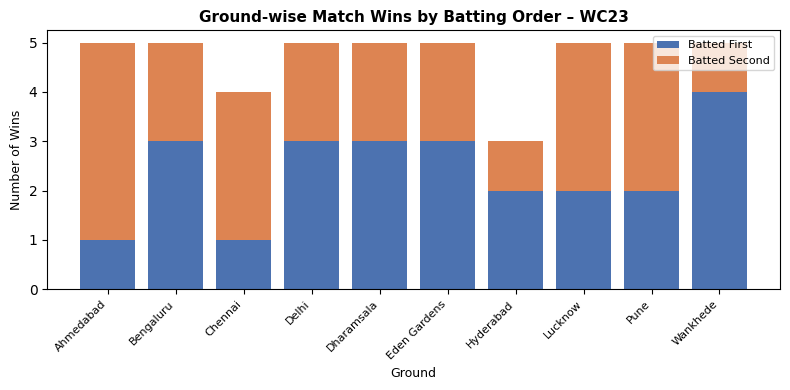

In [25]:
import matplotlib.pyplot as plt

# Identify batting-order columns dynamically
order_cols = [col for col in ground_batting_wins.columns if col != "Ground"]

bat_first = ground_batting_wins[order_cols[0]]
bat_second = ground_batting_wins[order_cols[1]]

grounds = ground_batting_wins["Ground"]

plt.figure(figsize=(8, 4))

plt.bar(grounds, bat_first, label=order_cols[0], color="#4c72b0")
plt.bar(grounds, bat_second, bottom=bat_first, label=order_cols[1], color="#dd8452")

plt.title(
    "Ground-wise Match Wins by Batting Order – WC23",
    fontsize=11,
    weight="bold"
)
plt.xlabel("Ground", fontsize=9)
plt.ylabel("Number of Wins", fontsize=9)

plt.xticks(rotation=45, ha="right", fontsize=8)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()


In [21]:
ground_batting_wins["Chasing_Advantage"] = (
    ground_batting_wins.get("Batted Second", 0) -
    ground_batting_wins.get("Batted First", 0)
)

ground_batting_wins.sort_values("Chasing_Advantage", ascending=False)


Winner_Batting,Ground,Batted First,Batted Second,Chasing_Advantage
0,Ahmedabad,1,4,3
2,Chennai,1,3,2
8,Pune,2,3,1
7,Lucknow,2,3,1
1,Bengaluru,3,2,-1
3,Delhi,3,2,-1
5,Eden Gardens,3,2,-1
4,Dharamsala,3,2,-1
6,Hyderabad,2,1,-1
9,Wankhede,4,1,-3


In [22]:
df.groupby(["Ground", "Winner"]).size().reset_index(name="Wins")


,Ground,Winner,Wins
0,Ahmedabad,Australia,2
1,Ahmedabad,India,1
2,Ahmedabad,New Zealand,1
3,Ahmedabad,South Africa,1
4,Bengaluru,Australia,1
5,Bengaluru,India,1
6,Bengaluru,New Zealand,1
7,Bengaluru,Pakistan,1
8,Bengaluru,Sri Lanka,1
9,Chennai,Afghanistan,1


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

ground_winner = (
    df.groupby(["Ground", "Winner"])
    .size()
    .reset_index(name="Wins")
)

# pick top winner per ground
top_ground_winner = (
    ground_winner
    .sort_values(["Ground", "Wins"], ascending=[True, False])
    .groupby("Ground")
    .head(1)
)


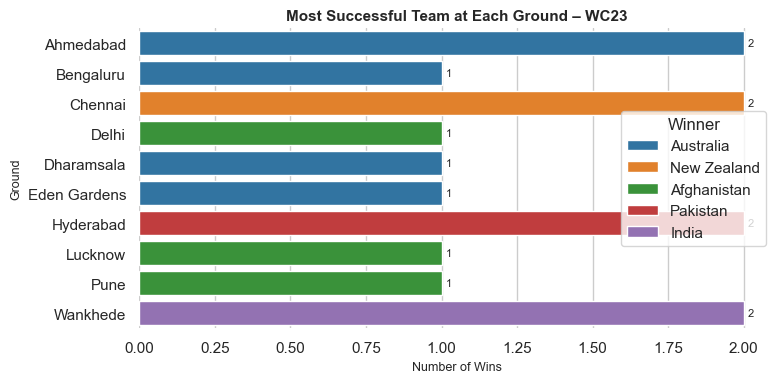

In [27]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 4))

ax = sns.barplot(
    data=top_ground_winner,
    x="Wins",
    y="Ground",
    hue="Winner",
    dodge=False,
    palette="tab10"
)

ax.set_title(
    "Most Successful Team at Each Ground – WC23",
    fontsize=11,
    weight="bold"
)
ax.set_xlabel("Number of Wins", fontsize=9)
ax.set_ylabel("Ground", fontsize=9)

# value labels
for container in ax.containers:
    ax.bar_label(container, padding=3, fontsize=8)

sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()
